# Usage of the QNN with PYNQ

In this notebook we are going to show you how to control the neural network using Python. The first thing to do is to load the overlat generated with Vivado (in the same folder there must be the .bit file and the .hwh one).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pynq import Overlay
overlay = Overlay('/home/xilinx/pynq/overlays/gas_nn/gas_nn.bit')

Once the overlay is loaded, the model can be initilizaed as following.

In [3]:
model = overlay.gas_nn

One can try to use `model.register_map` but the size of the registeres seems to be incompatible with this functionality, so we need to code an specific driver to use the neural network block.

In [4]:
model.register_map

/usr/local/lib/python3.6/dist-packages/pynq/registers.py:422: UserWarning: Unsupported register size 1024 for register Memory_w01_V
  v[2], k
/usr/local/lib/python3.6/dist-packages/pynq/registers.py:422: UserWarning: Unsupported register size 1024 for register Memory_w12_V
  v[2], k


TypeError: ufunc 'right_shift' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## The driver

First we need to finde the port configuration. In the Vivado HLS implementation it has been generated, been saved in the dollowing file.  `.../[HLSproyect]/[solutionX]/impl/misc/drivers/[ip_block_name]/src/x[ip_block_name]_hw.h`

In our case, this contains

```
// ==============================================================
// Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
// Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.
// ==============================================================
// AXILiteS
// 0x0020 ~
// 0x003f : Memory 'in_V' (16 * 12b)
//          Word n : bit [11: 0] - in_V[2n]
//                   bit [27:16] - in_V[2n+1]
//                   others      - reserved
// 0x0400 ~
// 0x07ff : Memory 'w01_V' (512 * 12b)
//          Word n : bit [11: 0] - w01_V[2n]
//                   bit [27:16] - w01_V[2n+1]
//                   others      - reserved
// 0x0800 ~
// 0x083f : Memory 'b01_V' (32 * 12b)
//          Word n : bit [11: 0] - b01_V[2n]
//                   bit [27:16] - b01_V[2n+1]
//                   others      - reserved
// 0x0c00 ~
// 0x0fff : Memory 'w12_V' (384 * 12b)
//          Word n : bit [11: 0] - w12_V[2n]
//                   bit [27:16] - w12_V[2n+1]
//                   others      - reserved
// 0x1000 ~
// 0x101f : Memory 'b12_V' (12 * 12b)
//          Word n : bit [11: 0] - b12_V[2n]
//                   bit [27:16] - b12_V[2n+1]
//                   others      - reserved
// 0x1040 ~
// 0x107f : Memory 'w23_V' (24 * 12b)
//          Word n : bit [11: 0] - w23_V[2n]
//                   bit [27:16] - w23_V[2n+1]
//                   others      - reserved
// 0x1080 ~
// 0x1087 : Memory 'b23_V' (2 * 12b)
//          Word n : bit [11: 0] - b23_V[2n]
//                   bit [27:16] - b23_V[2n+1]
//                   others      - reserved
// 0x1088 ~
// 0x108f : Memory 'out_V' (2 * 12b)
//          Word n : bit [11: 0] - out_V[2n]
//                   bit [27:16] - out_V[2n+1]
//                   others      - reserved
// (SC = Self Clear, COR = Clear on Read, TOW = Toggle on Write, COH = Clear on Handshake)

```

Using the DefaultIP driver functions write and read, we can code an specific driver to write and read the information we want in the ports we need.

In [5]:
from pynq import DefaultIP
from bitstring import Bits

class GasNN(DefaultIP):
    def __init__(self,description):
        super().__init__(description=description)
    
    def set_params(self, path_pesos):
        
        """
        It allows to write the parameters on the IP.
        The input must be a valid .npz file with the
        parameters sorted as following: 'w01', 'b01',
        'w12', 'b12', 'w23', 'b23'
        """
        w01 = np.load(path_pesos)['w01']
        b01 = np.load(path_pesos)['b01']
        w12 = np.load(path_pesos)['w12']
        b12 = np.load(path_pesos)['b12']
        w23 = np.load(path_pesos)['w23']
        b23 = np.load(path_pesos)['b23']
        
        #Starting with the w01 matrix weights
        self.write_array(w01.flatten('F'), 0x0400)
        #The same with b01 y and the others. The bias are already flatten.
        self.write_array(b01, 0x0800)
            
        self.write_array(w12.flatten('F'), 0x0c00)
        self.write_array(b12, 0x1000)
        
        self.write_array(w23.flatten('F'), 0x1040)  
        self.write_array(b23, 0x1080)
            
    def pred(self, gassens):

        """
        Use it to predict the gas concentration based
        on the gassens levels. It returns the
        concentration of the CH4 and the C2H4
        """
        from time import sleep
        
        self.write_array(gassens, 0x0020)
        
        sleep(1e-3)
        
        out = Bits(int=self.read(0x1088), length=32)
        eth=(out[4:16]).int/(2**9)
        ch4=(out[20:]).int/(2**9)

        return ch4, eth
    
    def write_array(self, inputArray, offset):
        """
        It recieves and array and an initial offset and writes the
        array data starting from the initial offset register usign
        the following format:
        Memory 'inputArray' (512 * 12b)
                           Word n : bit [11: 0] - inputArray[2n]
                                    bit [27:16] - inputArray[2n+1]
                                    others      - reserved
        """
        for i in range(int(len(inputArray)/2)):
            try:
                self.write(offset,('0b0000'+Bits(int=int(round(inputArray[2*i+1]*(2**9))), length=12)+
                                   '0b0000'+Bits(int=int(round(inputArray[2*i]*(2**9))), length=12)).int)
            except:
                print(inputArray[2*i], inputArray[2*i+1])
                print(round(inputArray[2*i]*(2**9)), round(inputArray[2*i+1]*(2**9)))
                raise
            
            offset+=4
        
    
    bindto = [overlay.ip_dict['gas_nn']['type']] #This should be 'xilinx.com:hls:gas_nn:1.0'
    
        
        
        

## How to use it
It is necessary to reload the overlay to assing the new driver to the xilinx.com:hls:gas_nn:1.0 block

In [6]:
overlay = Overlay('/home/xilinx/pynq/overlays/gas_nn/gas_nn.bit')

In [7]:
model = overlay.gas_nn

The parameters can be loaded as

In [8]:
model.set_params('eth-ch4-params-quant.npz')

We read the filtered time series in order to predict it

In [9]:
t, CH4, Eth = np.loadtxt('ethylene_methane.txt', skiprows=1, usecols=(0,1,2), unpack=True)
sens = np.loadtxt('ethylene_methane.txt', skiprows=1, usecols=(3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18))

Now we can try to predict one element of the time series

In [10]:
elto=258
print('\t\t   CH4    C2H4\nModel predictions:', model.pred(sens[elto,:]), '\nActual values:   ', CH4[elto], Eth[elto])

		   CH4    C2H4
Model predictions: (0.375, 0.51171875) 
Actual values:    0.337074864327 0.5


It works! Let's try in all the time series

In [11]:
CH4FPGA = np.empty_like(CH4)
EthFPGA = np.empty_like(Eth)
for i in range(len(t)):
    (CH4FPGA[i], EthFPGA[i]) = model.pred(sens[i, :])
    
CH4max, CH4min, Ethmax, Ethmin = 296.67, 0.0, 20.0, 0.0

errCH4 = np.abs(((CH4FPGA-CH4)*(CH4max-CH4min)+CH4min)/(CH4max-CH4min))*100
errEth = np.abs(((EthFPGA-Eth)*(Ethmax-Ethmin)+Ethmin)/(Ethmax-Ethmin))*100


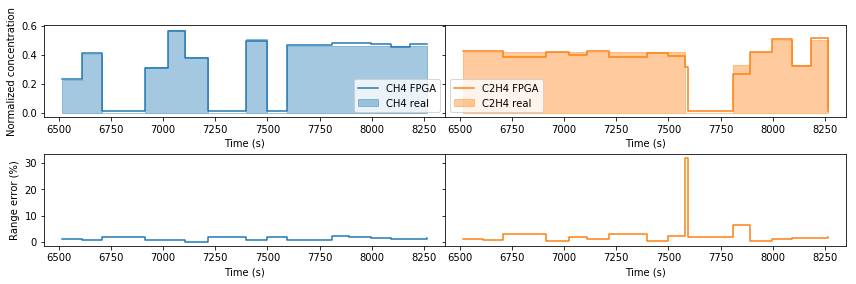

In [12]:
orig = 6350
fin = orig + 2000

fig, axs = plt.subplots(nrows=2, ncols=2,  sharey='row', figsize=(12.0,4.0))

axs[0,0].fill_between(t[np.logical_and(orig<t, t<fin)], CH4[np.logical_and(orig<t, t<fin)], color='C0', alpha=0.4, step='post', label='CH4 real')
axs[0,1].fill_between(t[np.logical_and(orig<t, t<fin)], Eth[np.logical_and(orig<t, t<fin)], color='C1', alpha=0.4, step='post', label='C2H4 real')

axs[0,0].step(t[np.logical_and(orig<t, t<fin)], CH4FPGA[np.logical_and(orig<t, t<fin)], 'C0--', where='post', label='CH4 FPGA')
axs[0,1].step(t[np.logical_and(orig<t, t<fin)], EthFPGA[np.logical_and(orig<t, t<fin)], 'C1--', where='post', label='C2H4 FPGA')

#ax2.step(t[np.logical_and(orig<t, t<fin)], errTot[np.logical_and(orig<t, t<fin)], 'gray', where='post', label='Error total')
axs[1,0].step(t[np.logical_and(orig<t, t<fin)], errCH4[np.logical_and(orig<t, t<fin)], 'C0:', where='post', label='Error CH4')
axs[1,1].step(t[np.logical_and(orig<t, t<fin)], errEth[np.logical_and(orig<t, t<fin)], 'C1:', where='post', label='Error C2H4')


for i in range(2): 
    for j in range(2): axs[i,j].set_xlabel('Time (s)')
axs[0,0].set_ylabel('Normalized concentration')
axs[1,0].set_ylabel('Range error (%)')

axs[0,0].legend(loc='lower right')
axs[0,1].legend(loc='lower left')

plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.4)

plt.savefig("time-series-FPGA-12-3-"+str(orig)+"-"+str(fin)+".png",dpi=600)


In [14]:
np.average(errCH4),np.average(errEth)

(2.5184265492320534, 2.5414711676217765)

Save the data

In [13]:
np.savez('time-series-fpga.npz', CH4FPGA=CH4FPGA, EthFPGA=EthFPGA)